## **Travel Salesman Problem using K-Means Constrained Clustering**

Data yang digunakan diperoleh dari kaggle dengan judul : **Transactional Retail Dataset of Electronics Store**

Problem Case : Untuk menentukan lokasi yang harus dituju oleh salesman dengan optimasi cost seminimum mungkin dengan memperhatikan jarak antar lokasi customer merupakan challenge bagi perusahaan. Oleh karena itu dibutuhkan sebuah algoritma yang mampu menjawab tantangan tersebut. 


Jawaban dari tantangan tersebut adalah k-means constrained. Tujuan dari analisis ini adalah ingin membagi rata jumlah customer yang harus dicover dan dikunjungi oleh salesman berdasarkan jarak lokasi customer. Alasan menggunakan k-means constrained karena algoritma tersebut mampu membagi rata jumlah data percluster dan dapat menentukan size minimum dan size maksimum untuk setiap clusternya. 

In [ ]:
#Install k-means-constrained dari PyPI
! pip install k-means-constrained

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Install Pillow untuk load data image
! pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd 

In [ ]:
data = pd.read_excel("dirty_data.xlsx")

In [ ]:
data.head()  

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD182494,ID6197211592,6/22/2019,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('iS...",12200,79.89,-37.815105,144.932843,10,11059.89,Winter,True,1.2800,perfect phone and trusted seller. phone itself...,True
1,ORD395518,ID0282825849,12/29/2019,Thompson,"[('Thunder line', 1), ('Universe Note', 2)]",9080,62.71,-37.802736,144.951118,0,9142.71,Summer,False,1.1621,it keeps dropping calls the wifi don't work th...,False
2,ORD494479,ID0579391891,3/2/2019,Nickolson,"[('Thunder line', 1), ('pearTV', 2)]",10670,65.87,-37.821302,144.957581,10,9668.87,Autumn,False,1.0949,five stars this is a great cheap phone.,True
3,ORD019224,ID4544561904,1/12/2019,Nickolson,"[('Universe Note', 1), ('Alcon 10', 2), ('Oliv...",24800,57.61,-37.811416,144.973073,15,21137.61,Summer,False,0.8571,charger did not fit the charger didn't fit.,False
4,ORD104032,ID6231506320,11/28/2019,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1), ('i...",9145,75.54,-37.823859,144.969892,25,6934.29,Spring,False,0.5867,four stars good,True


Data describe digunakan untuk mengetahui summary dari data yang ingin kita analisis. Berdasarkan tampilan dibawah, kita bisa mengetahui rata-rata, median, nilai quartile, dan nilai minimal maksimal untuk data dengan tipe numerik.

In [ ]:
data.describe() 

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse
count,493.000000,493.000000,493.000000,493.000000,493.000000,4.930000e+02,493.000000
mean,25692.328600,76.705132,-37.812266,144.969467,10.902637,3.959502e+04,2.220571
std,86931.474526,14.436274,0.007455,0.022714,8.657123,2.761180e+05,8.873717
min,585.000000,46.350000,-37.827123,144.924967,0.000000,6.392900e+02,0.107800
25%,7050.000000,66.010000,-37.818488,144.953478,5.000000,6.419500e+03,0.751500
50%,12805.000000,76.330000,-37.812585,144.965439,10.000000,1.120314e+04,1.030300
75%,20360.000000,82.780000,-37.806254,144.983824,15.000000,1.827406e+04,1.408600
max,947691.000000,114.040000,-37.789119,145.019837,25.000000,5.688270e+06,94.973400


In [ ]:
print(f'Dimensi dari datanya yaitu : {data.shape}')

Dimensi dari datanya yaitu : (493, 16)


Dimensi dari data yang akan dianalisis yaitu terdiri dari 493 baris dan 16 kolom.

In [ ]:
print(data.isnull().sum())

order_id                         0
customer_id                      0
date                             0
nearest_warehouse                0
shopping_cart                    0
order_price                      0
delivery_charges                 0
customer_lat                     0
customer_long                    0
coupon_discount                  0
order_total                      0
season                           0
is_expedited_delivery            0
distance_to_nearest_warehouse    0
latest_customer_review           0
is_happy_customer                0
dtype: int64


Berdasarkan output diatas untuk semua kolom dari data tidak mengandung nilai yang kosong(NA/None/Null).

In [ ]:
x = data.iloc[:,7:9]
x

,customer_lat,customer_long
0,-37.815105,144.932843
1,-37.802736,144.951118
2,-37.821302,144.957581
3,-37.811416,144.973073
4,-37.823859,144.969892
...,...,...
488,-37.817662,144.970405
489,-37.815469,144.968083
490,-37.805979,144.966101
491,-37.820071,144.984435


Concern data yang akan digunakan untuk analisis kali ini yaitu **customer_lat** dan **customer_long** untuk mendapatkan cluster berdasarkan jarak antar alamat customer. 

In [ ]:
latlong = x[['customer_lat', 'customer_long']].to_numpy()

## **Membuat model k-means constrained**

In [ ]:
from k_means_constrained import KMeansConstrained
clf = KMeansConstrained(
    n_clusters=10,
    size_min=45,
    size_max=50,
    random_state=0
)

**Notes :**
Dalam case study kali ini mengambil contoh kasus apabila **perusahaan merekrut 10 orang untuk menjadi salesman** agar melakukan traveling ke customer-customer yang pernah membeli dan berlangganan. Karena ada 10 orang yang direkrut sehingga **n_cluster yang dipilih yaitu 10**.

In [ ]:
clusters = clf.fit_predict(latlong)
clusters

array([6, 0, 5, 4, 9, 3, 0, 7, 3, 6, 3, 5, 0, 9, 4, 8, 4, 9, 4, 9, 3, 8,
       2, 8, 7, 3, 3, 3, 2, 5, 1, 2, 0, 0, 6, 0, 8, 2, 2, 3, 0, 5, 0, 4,
       7, 0, 1, 3, 6, 5, 9, 3, 7, 9, 1, 8, 1, 7, 3, 3, 8, 7, 2, 7, 9, 9,
       6, 2, 4, 7, 9, 1, 0, 7, 7, 2, 8, 6, 9, 5, 9, 5, 4, 3, 6, 7, 3, 7,
       2, 0, 0, 3, 4, 4, 9, 7, 6, 3, 9, 3, 1, 4, 1, 9, 0, 5, 5, 8, 1, 5,
       8, 4, 8, 3, 3, 9, 0, 8, 8, 4, 6, 1, 1, 1, 9, 7, 5, 7, 9, 2, 0, 2,
       4, 5, 4, 3, 3, 6, 9, 6, 4, 6, 3, 1, 8, 1, 8, 8, 3, 2, 1, 9, 3, 0,
       0, 3, 5, 0, 3, 2, 2, 1, 6, 1, 2, 2, 1, 5, 4, 2, 1, 0, 1, 4, 8, 2,
       6, 1, 6, 8, 7, 4, 0, 0, 9, 5, 7, 6, 9, 4, 5, 0, 8, 4, 0, 0, 8, 0,
       2, 6, 7, 4, 0, 5, 3, 6, 6, 8, 5, 6, 3, 4, 9, 7, 9, 9, 1, 9, 0, 6,
       3, 2, 6, 2, 8, 3, 5, 5, 5, 0, 8, 2, 1, 2, 7, 6, 5, 4, 8, 6, 4, 4,
       2, 7, 7, 5, 7, 9, 7, 6, 2, 2, 8, 2, 6, 4, 3, 6, 0, 0, 9, 8, 2, 7,
       7, 4, 9, 9, 0, 3, 6, 0, 1, 5, 6, 6, 4, 7, 0, 4, 4, 5, 3, 0, 5, 9,
       8, 3, 7, 6, 4, 1, 0, 5, 8, 4, 4, 7, 1, 3, 4,

In [ ]:
data_clusters = data.copy() 
data_clusters['cluster'] = clusters

In [ ]:
df = pd.DataFrame(data_clusters)

Setelah mendapatkan data cluster berdasarkan latlong data, perlu dilakukan pengkategorian untuk setiap cluster akan dicover oleh user_salesman siapa. Maka perlu menambahkan kolom, yaitu "user_salesman". 

In [ ]:
df.insert(17, column='user_salesman', value=df['cluster'])

In [ ]:
mapping={0 : 'Salesman-001',
         1 : 'Salesman-002',
         2 : 'Salesman-003',
         3 : 'Salesman-004',
         4 : 'Salesman-005',
         5 : 'Salesman-006',
         6 : 'Salesman-007',
         7 : 'Salesman-008',
         8 : 'Salesman-009',
         9 : 'Salesman-010'}

In [ ]:
df[['user_salesman']] = df[['user_salesman']].applymap(mapping.get)
df

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,cluster,user_salesman
0,ORD182494,ID6197211592,6/22/2019,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('iS...",12200,79.89,-37.815105,144.932843,10,11059.89,Winter,True,1.2800,perfect phone and trusted seller. phone itself...,True,6,Salesman-007
1,ORD395518,ID0282825849,12/29/2019,Thompson,"[('Thunder line', 1), ('Universe Note', 2)]",9080,62.71,-37.802736,144.951118,0,9142.71,Summer,False,1.1621,it keeps dropping calls the wifi don't work th...,False,0,Salesman-001
2,ORD494479,ID0579391891,3/2/2019,Nickolson,"[('Thunder line', 1), ('pearTV', 2)]",10670,65.87,-37.821302,144.957581,10,9668.87,Autumn,False,1.0949,five stars this is a great cheap phone.,True,5,Salesman-006
3,ORD019224,ID4544561904,1/12/2019,Nickolson,"[('Universe Note', 1), ('Alcon 10', 2), ('Oliv...",24800,57.61,-37.811416,144.973073,15,21137.61,Summer,False,0.8571,charger did not fit the charger didn't fit.,False,4,Salesman-005
4,ORD104032,ID6231506320,11/28/2019,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1), ('i...",9145,75.54,-37.823859,144.969892,25,6934.29,Spring,False,0.5867,four stars good,True,9,Salesman-010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,ORD475510,ID0247417082,8/7/2019,Nickolson,"[('Alcon 10', 2), ('iAssist Line', 2)]",386776,59.70,-37.817662,144.970405,10,20174.70,Winter,True,0.1282,i bought this phone to send to my sister in .....,False,9,Salesman-010
489,ORD086060,ID0130015098,3/28/2019,Nickolson,"[('pearTV', 2), ('Candle Inferno', 2), ('Toshi...",22120,62.29,-37.815469,144.968083,0,22182.29,Autumn,True,0.3711,one star it was the wrong phone,False,9,Salesman-010
490,ORD079320,ID2707985442,10/16/2019,Nickolson,"[('pearTV', 1), ('Alcon 10', 1), ('Lucent 330S...",16490,106.98,-37.805979,144.966101,0,16596.98,Spring,True,1.4368,love this phone! has many great features!,True,7,Salesman-008
491,ORD026546,ID0060088412,5/19/2019,Nickolson,"[('iStream', 1), ('Candle Inferno', 1), ('iAss...",5030,79.89,-37.820071,144.984435,10,4606.89,Autumn,True,1.3191,spoiled son's birthday present son wanted one ...,True,1,Salesman-002


In [ ]:
df_final = df.loc[0:492,['user_salesman','customer_lat','customer_long','cluster']]
df_final

,user_salesman,customer_lat,customer_long,cluster
0,Salesman-007,-37.815105,144.932843,6
1,Salesman-001,-37.802736,144.951118,0
2,Salesman-006,-37.821302,144.957581,5
3,Salesman-005,-37.811416,144.973073,4
4,Salesman-010,-37.823859,144.969892,9
...,...,...,...,...
488,Salesman-010,-37.817662,144.970405,9
489,Salesman-010,-37.815469,144.968083,9
490,Salesman-008,-37.805979,144.966101,7
491,Salesman-002,-37.820071,144.984435,1


In [ ]:
#untuk mengeksport data chasil analisis
df_final.to_excel('hasil_final.xlsx', sheet_name = 'Sheet 1')

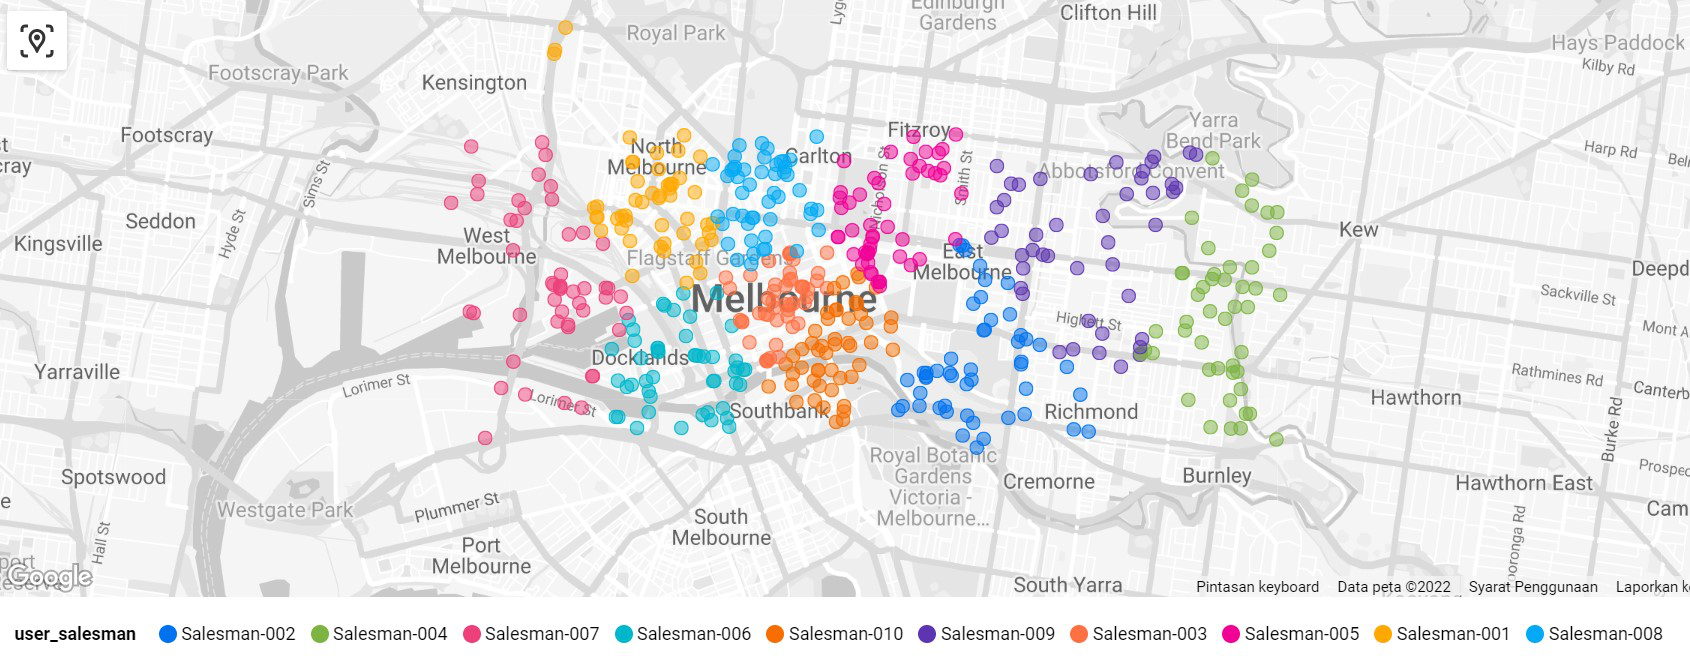

In [21]:
#menampilkan rute lokasi customer untuk setiap salesman(menggunakan google data studio)
from PIL import Image
datviz_cluster = Image.open('k-means constrained.jpg')
datviz_cluster

SOURCE :

https://github.com/joshlk/k-means-constrained

https://towardsdatascience.com/advanced-k-means-controlling-groups-sizes-and-selecting-features-a998df7e6745

Data :
https://www.kaggle.com/datasets/muhammadshahrayar/transactional-retail-dataset-of-electronics-store